## Импорты

In [2]:
from IPython.display import clear_output
%pip install skimpy
%pip install --user linear-tree
%pip install --upgrade pip
%pip install --user --upgrade Pillow
%pip install --upgrade matplotlib
%pip install ydata_profiling
%pip install optuna
clear_output()

In [2]:
import pandas as pd
import numpy as np
import math

from ydata_profiling import ProfileReport
import skimpy
import sys
import time
from datetime import datetime

from IPython.display import Markdown
import nbformat

import optuna
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lineartree import LinearTreeRegressor, LinearForestRegressor
from lineartree import LinearBoostRegressor

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
# plt.style.use('default')
plt.style.use('dark_background') # я работаю в темной теме, поэтому использую эту настройку.
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

s = 42

## Обзор данных

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

dfs = [train, test]
dfs_names = ['train', 'test']

In [ ]:
for i in range(len(dfs)):
    display(skimpy.skim(dfs[i]))

In [4]:
train['saledate'] = pd.to_datetime(pd.to_datetime(train['saledate'], utc=True).dt.date)
test['saledate'] = pd.to_datetime(pd.to_datetime(test['saledate'], utc=True).dt.date)

test['year'] = pd.to_datetime(test['year'],format='%Y')
train['year'] = pd.to_datetime(train['year'],format='%Y')

test['lifetime'] = (test['saledate'] - pd.to_datetime(train['year'], format='%Y-%m-%d')).dt.days
train['lifetime'] = (train['saledate'] - pd.to_datetime(train['year'], format='%Y-%m-%d')).dt.days

In [5]:
for i in range(len(dfs)):
    df = dfs[i]
    df['saledate'] = pd.to_datetime(pd.to_datetime(df['saledate'], utc=True).dt.date)
    df['year'] = pd.to_datetime(df['year'],format='%Y')
    df['lifetime'] = np.abs((df['saledate'] - pd.to_datetime(df['year'], format='%Y-%m-%d'))).dt.days
    df['km/day'] = np.where(df['lifetime'] == 0, 0, np.abs(df['odometer'] / df['lifetime']))

test = test.drop('saledate',axis=1)
train = train.drop('saledate',axis=1)

In [ ]:
ProfileReport(train)

In [ ]:
ProfileReport(test)

In [6]:
target = 'sellingprice'
cat_cols = ['make', 'model', 'trim', 'body', 'transmission','state','color','interior','seller']
num_cols = list(train.columns.drop(cat_cols+['vin']+[target]))

train[cat_cols] = train[cat_cols].fillna('unknown')
train[num_cols] = train[num_cols].fillna(train[num_cols].median())

test[cat_cols] = test[cat_cols].fillna('unknown')
test[num_cols] = test[num_cols].fillna(train[num_cols].median())

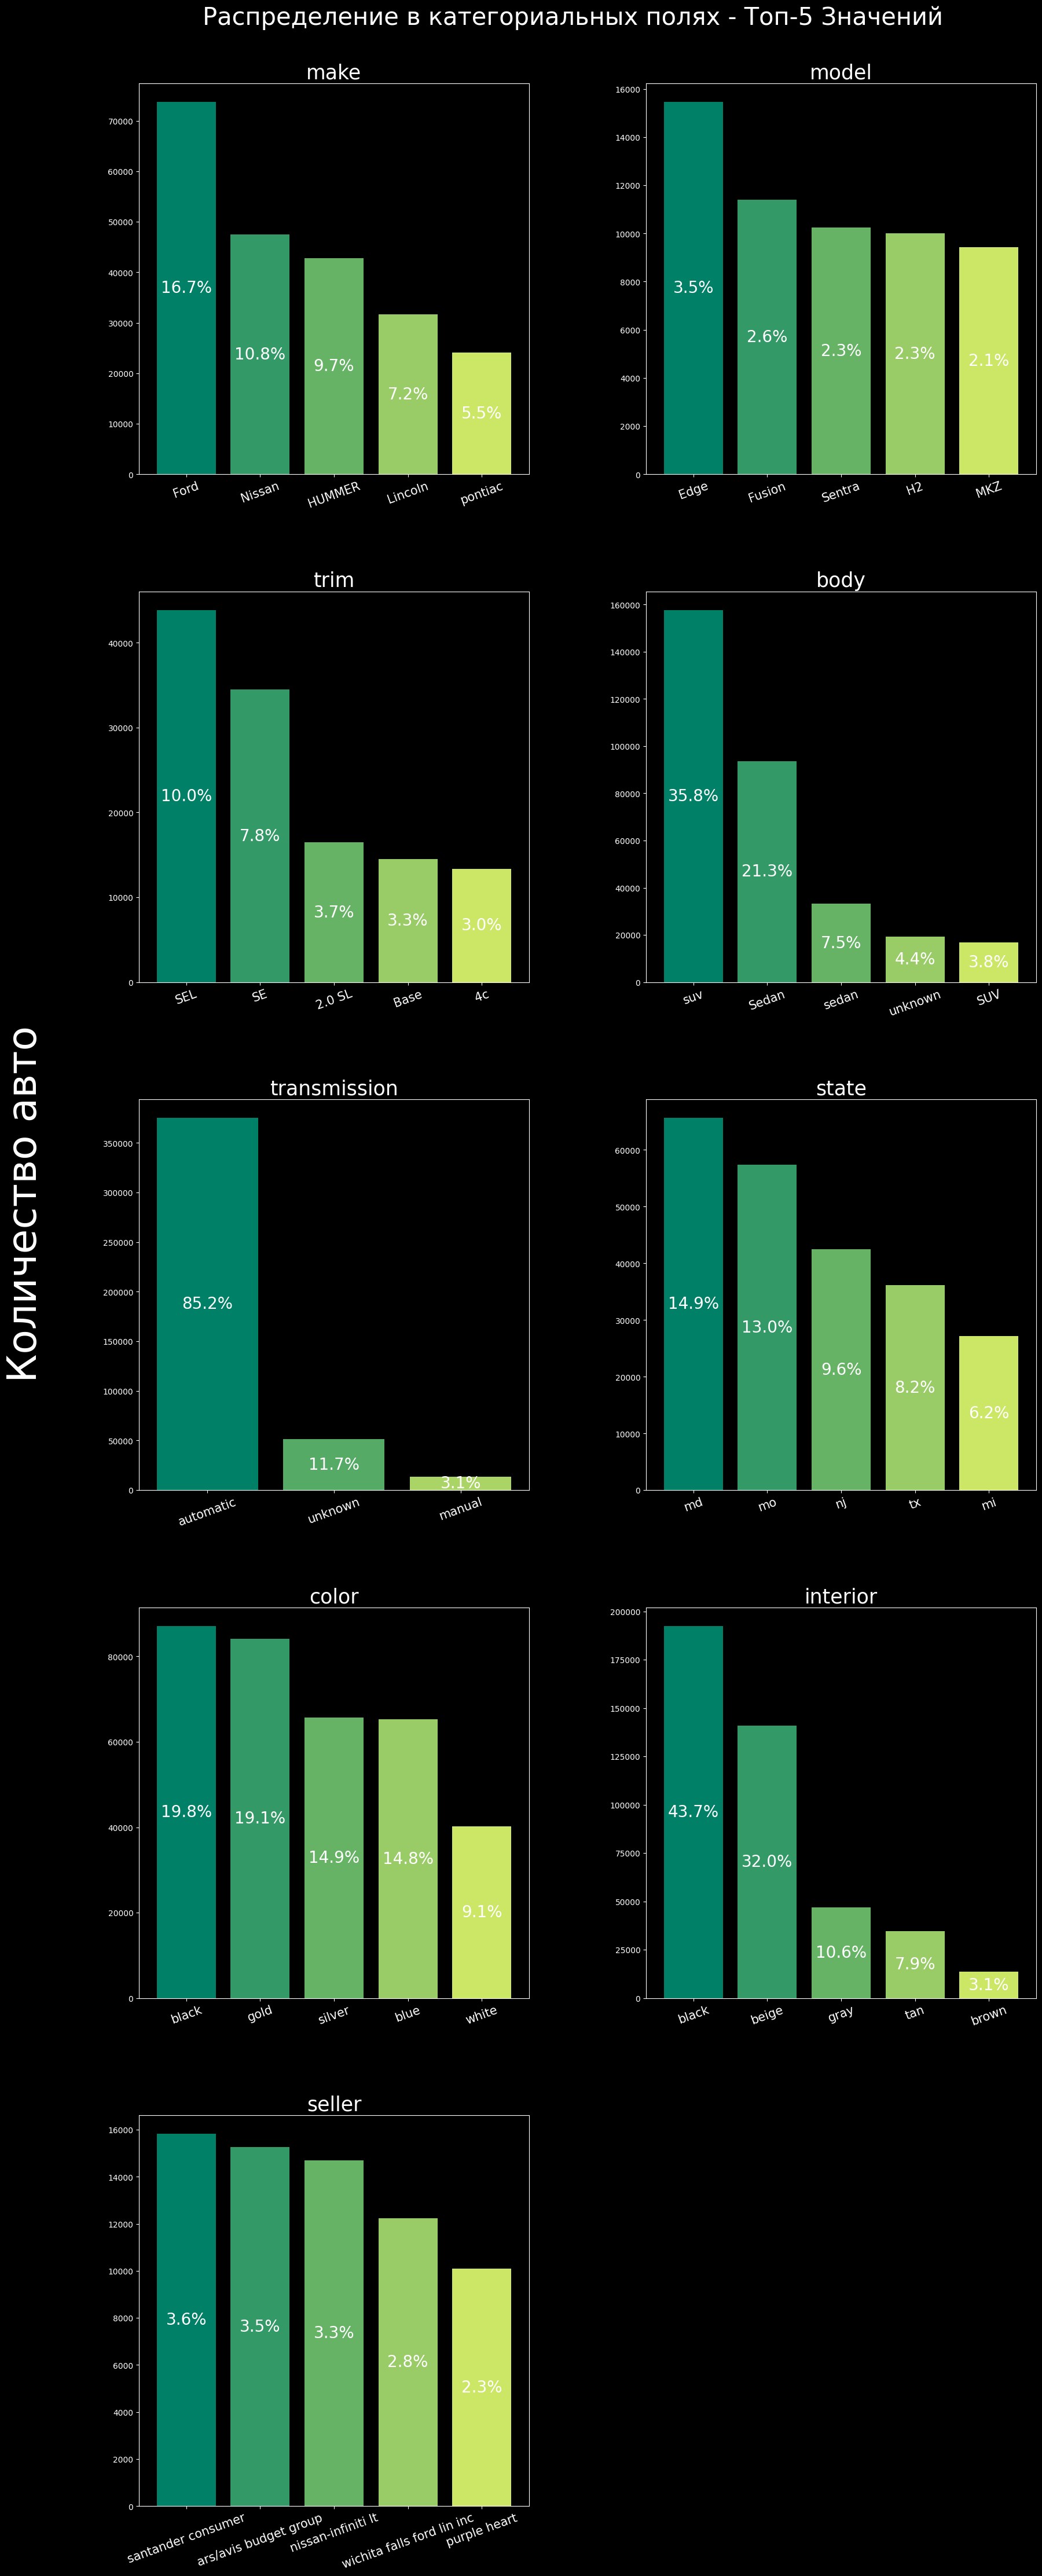

In [172]:

df = train.copy()

palette = plt.cm.summer
fig = plt.figure()
plot_num = 1
fig.text(0.01, 0.75, 'Количество авто', va='center', rotation='vertical', size=50) 

# цикл по столбцам
for col in cat_cols:
    ax = fig.add_subplot(len(cat_cols), 2, plot_num)
    value_counts = df[col].value_counts().head(5)  # Получаем топ-5 значений
    ax.bar(value_counts.index.map(str), value_counts.values)  # Отображаем только топ-5 баров
    ax.set_title(col,size=25)
 #   ax.set_ylabel('Количество пользователей',size=18) # если нужно будет добавить подпись оси Y на каждый график
    plot_num += 1
    
    x_tick_locations = np.arange(len(df[col].map(str).unique()))
    ax.set_xticks(x_tick_locations)
    ax.set_xticklabels(df[col].map(str).unique(), rotation=20,fontsize=15)
        
    # counts = df[col].value_counts()
    x = np.arange(len(value_counts))
    
    # цикл по барам
    for i, count in enumerate(value_counts):
        
        # вычисляем процентное соотношение для каждого бара
        percent = count / df[col].count() * 100
        
        # добавляем подпись с процентами
        ax.annotate('{:.1f}%'.format(percent), xy=(x[i], count/2), 
                    xytext=(0, -10), textcoords='offset points',
                    ha='center', va='bottom', fontsize=20)
        
        # добавляем цвет
        color = palette(i / len(value_counts))
        ax.bar(x[i], count, color=color)

               
fig.set_size_inches(20, 90)
fig.suptitle('Распределение в категориальных полях - Топ-5 Значений', fontsize=30)
fig.subplots_adjust(top=0.965,hspace=0.3,wspace=0.3)
plt.show()

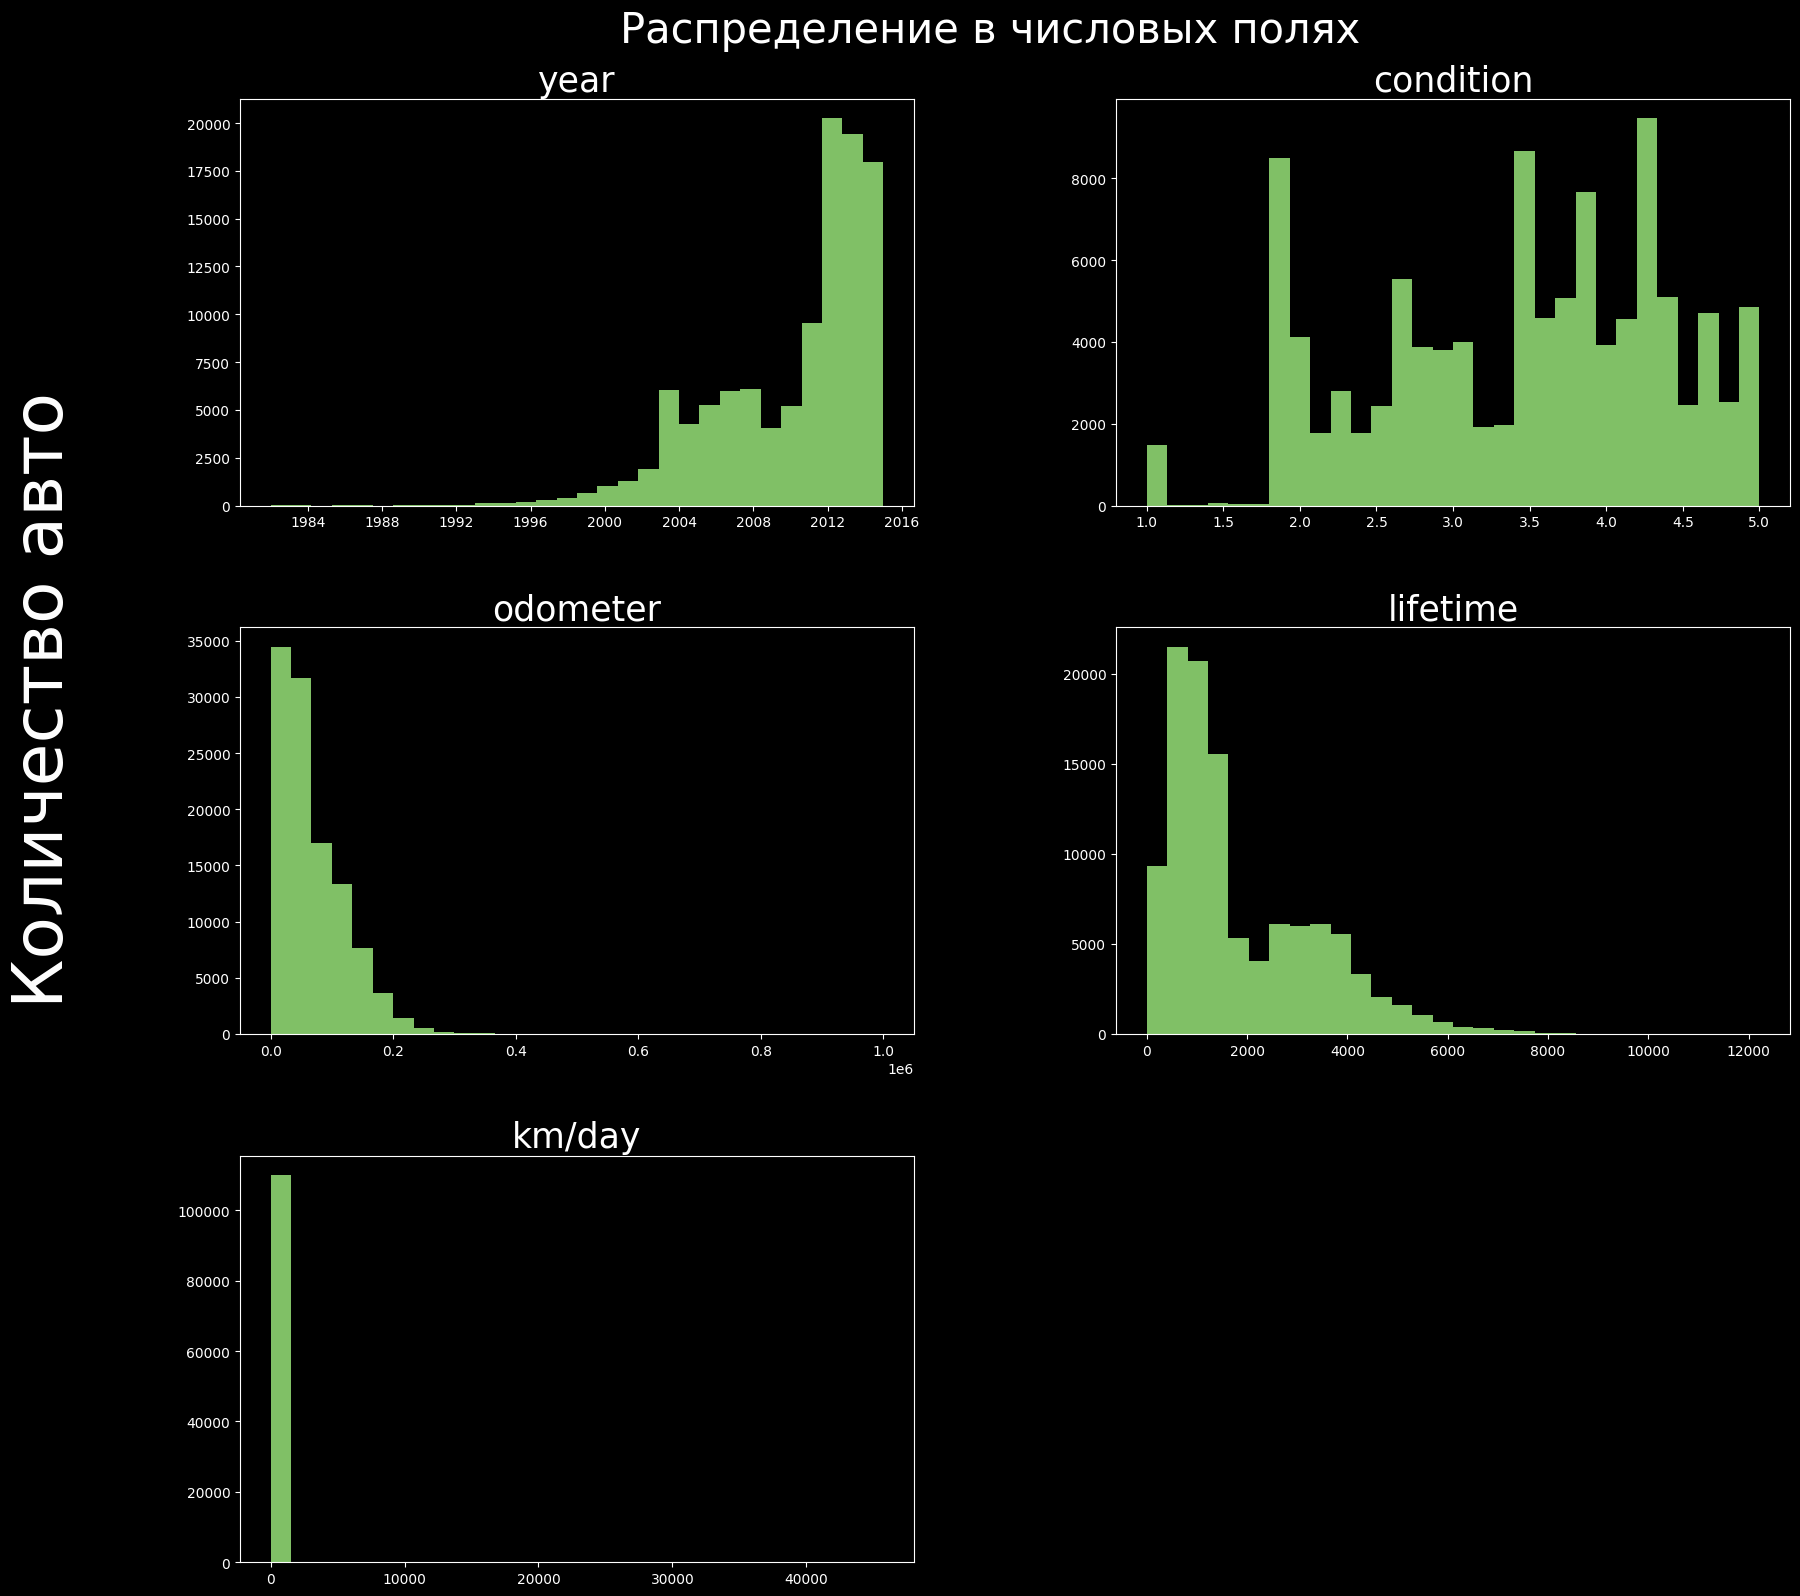

In [11]:
fig = plt.figure()
plot_num = 1
fig.text(0.01, 0.75, 'Количество авто', va='center', rotation='vertical', size=50) 

# цикл по столбцам
for col in num_cols:
    
    ax = fig.add_subplot(len(num_cols), 2, plot_num)
    ax.hist(df[col], bins=30, color=plt.cm.summer(0.5)) 
    ax.set_title(col,size=25)
#   ax.set_ylabel('Количество пользователей',size=18) # если нужно будет добавить подпись оси Y на каждый график
    plot_num += 1

fig.set_size_inches(20, 30)
fig.suptitle('Распределение в числовых полях', fontsize=30)
fig.subplots_adjust(top=0.95,hspace=0.3,wspace=0.3)
plt.show()

In [15]:
col = 'km/day'
display(train[col].sort_values().head(5))
display(train[col].sort_values().tail(5))
display(f'Среднее: {train[col].mean()}, Медиана: {train[col].median()}')

97329     0.0
2180      0.0
409159    0.0
254760    0.0
49792     0.0
Name: km/day, dtype: float64

394885    892.856250
342379    893.654155
160641    904.158228
150893    904.158228
288664    909.090000
Name: km/day, dtype: float64

'Среднее: 30.23286614611548, Медиана: 28.54494487224925'

In [14]:
col = 'km/day'
display(test[col].sort_values().head(5))
display(test[col].sort_values().tail(5))
display(f'Среднее: {test[col].mean()}, Медиана: {test[col].median()}')

21328     0.000000
27541     0.000000
87133     0.000000
70756     0.000000
106269    0.000105
Name: km/day, dtype: float64

108711    456.620548
62661     505.560667
89792     869.564348
70852     896.860090
38050     897.665171
Name: km/day, dtype: float64

'Среднее: 30.255580422383016, Медиана: 28.484740500776134'

In [9]:
def km_day_normilaze(df, km_day_cup=2000, lifetime_cup = False):

    if lifetime_cup == False:
        new_values = df.loc[df['km/day'] > km_day_cup, 'odometer'] / (df.loc[df['km/day'] > km_day_cup, 'lifetime'] + 365)
        df.loc[df['km/day'] > km_day_cup, 'lifetime'] += 365
        df.loc[df['km/day'] > km_day_cup, 'km/day'] = new_values

    else:
        new_values = (df.loc[(df['km/day']) > km_day_cup & (df['lifetime'] < lifetime_cup), 'odometer'] /
            (df.loc[(df['km/day']) > km_day_cup & (df['lifetime'] < lifetime_cup), 'lifetime'] + 365))

        df.loc[(df['km/day']) > km_day_cup & (df['lifetime'] < lifetime_cup), 'lifetime'] += 365
        df.loc[(df['km/day']) > km_day_cup & (df['lifetime'] < lifetime_cup), 'km/day'] = new_values

In [13]:
km_day_normilaze(test)
km_day_normilaze(test,200,365)
km_day_normilaze(train)
km_day_normilaze(train,200,365)

In [16]:
df = train.copy()

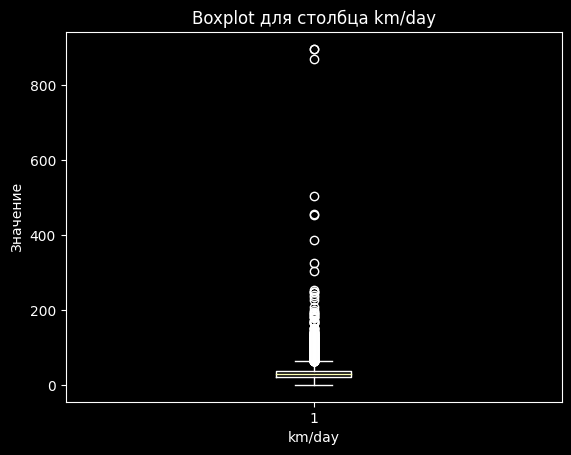

In [17]:
plt.boxplot(test['km/day'])

# Настройка осей и заголовка
plt.xlabel('km/day')
plt.ylabel('Значение')
plt.title('Boxplot для столбца km/day')

# Отображение графика

plt.show()

In [18]:
def groupby_left(df,column,agg):
    """Функция берёт на вход датафрейм, название столбца и название функций.
    По ним будет производиться группировка по столбцу с стоимостью авто."""
    return df.groupby(column)['sellingprice'].agg(agg)

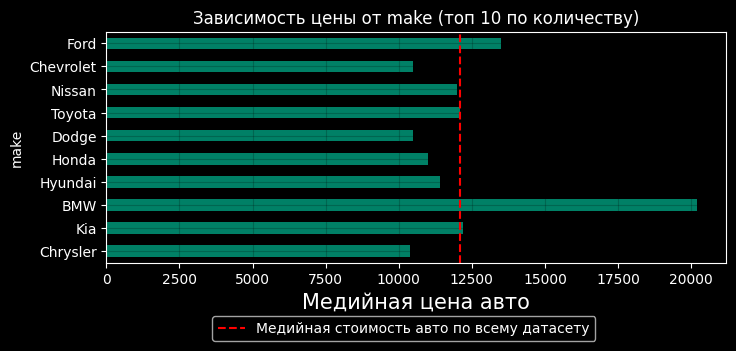

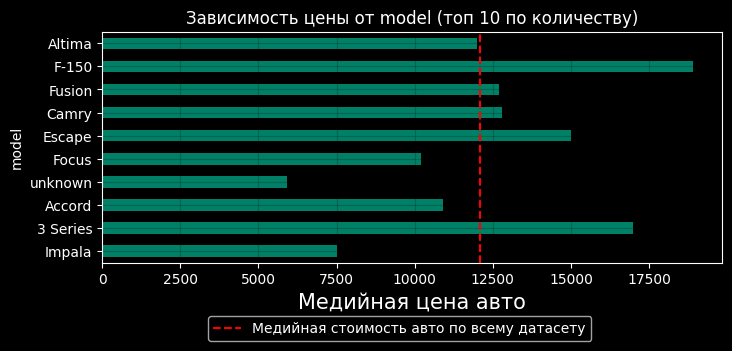

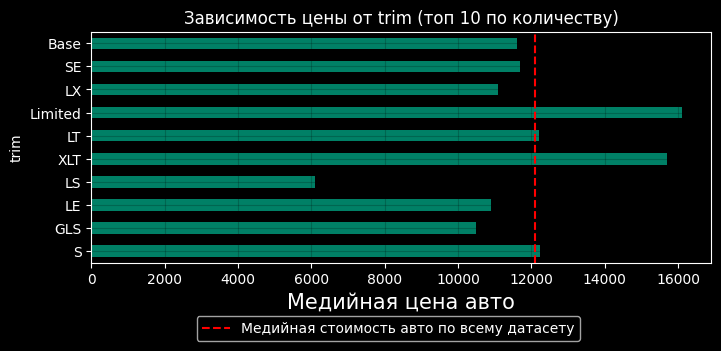

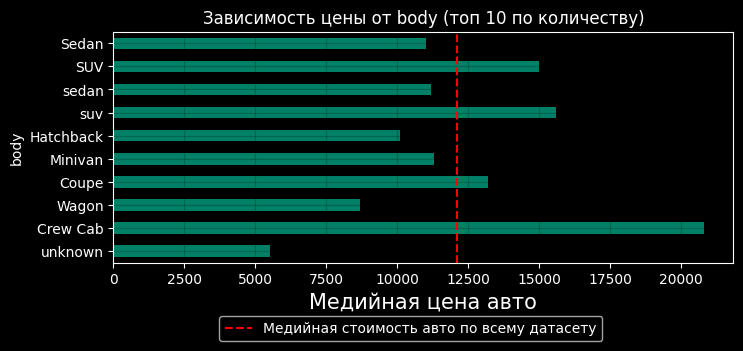

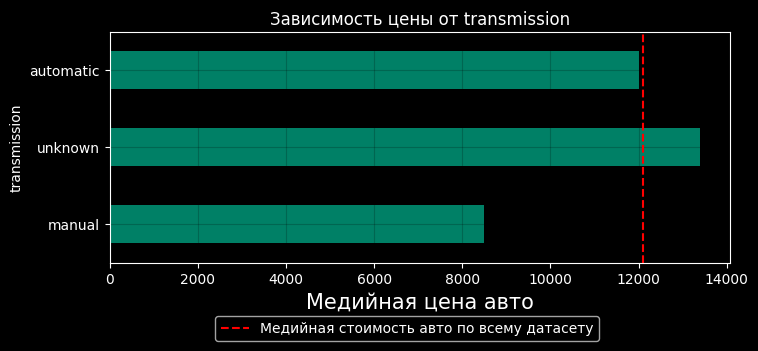

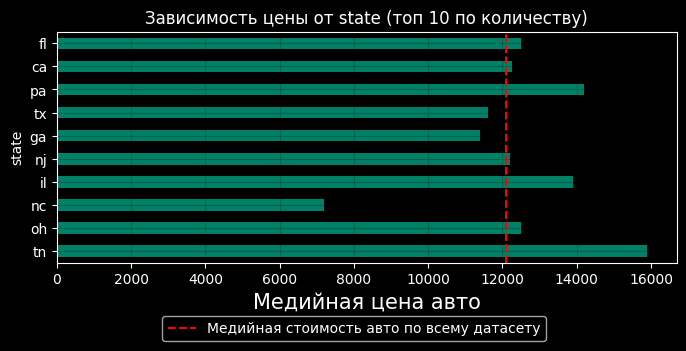

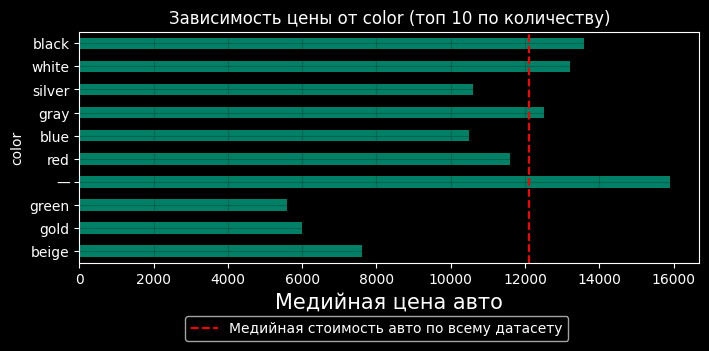

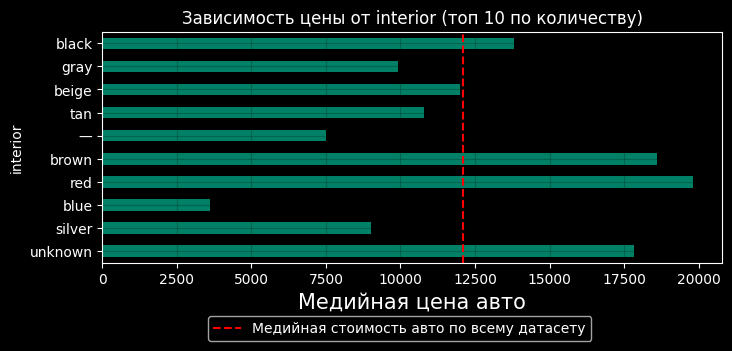

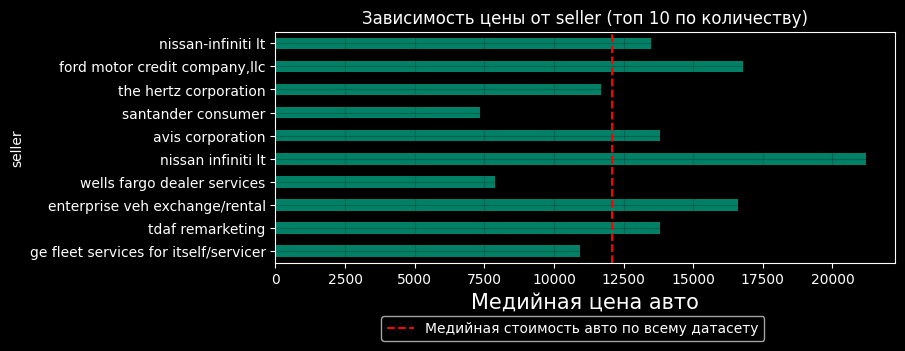

In [265]:
features = cat_cols + num_cols
cmap = plt.cm.summer(0.5)
agg = 'median'

for column in cat_cols:

    top = (groupby_left(df,column,['count',agg])
                       .sort_values(by = 'count', ascending = False)
                       .head(10).sort_values('count')[agg])
    plot = top.plot(kind='barh',cmap=plt.cm.summer, figsize=(8,3),rot=0,grid=True,legend=False)

    if df[column].unique().shape[0] >= 10:
        plt.title(f'Зависимость цены от {column} (топ 10 по количеству)')
    else:
        plt.title(f'Зависимость цены от {column}')

    plt.xlabel('Медийная цена авто',size = 15)
    plt.axvline(x=round(df[target].agg(agg),5),
                color='red', linestyle='--', 
                label='Средняя стоимость авто')
    
    means = round(groupby_left(df,column,[agg]).loc[:, agg],2)
    
    # for i, bar in enumerate(plot.get_children()[:len(means)]):
    #     bar.set_color(cmap(i / len(means)))
    
    # for x, y, label in zip(range(len(means)), means, means):
    #     plt.text(x, y+0.02, label, ha='center', va='bottom')
    plt
    plt.grid(color='black',alpha=0.2)
    plt.legend(['Медийная стоимость авто по всему датасету'],fontsize='medium',bbox_to_anchor=(0.8, -0.2))
    plt.show()

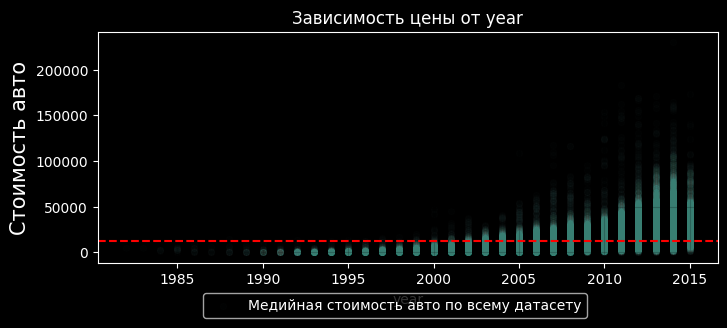

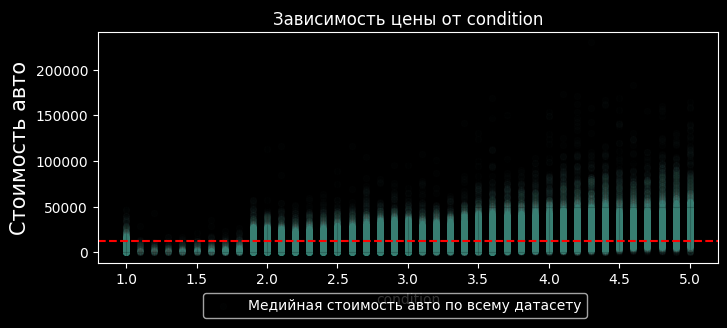

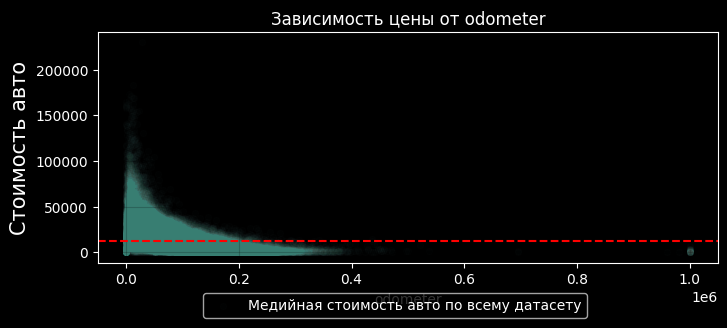

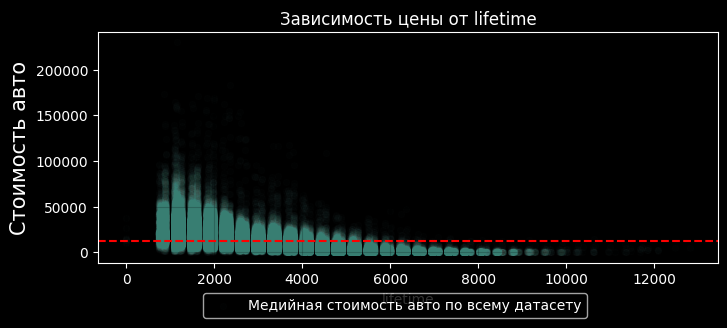

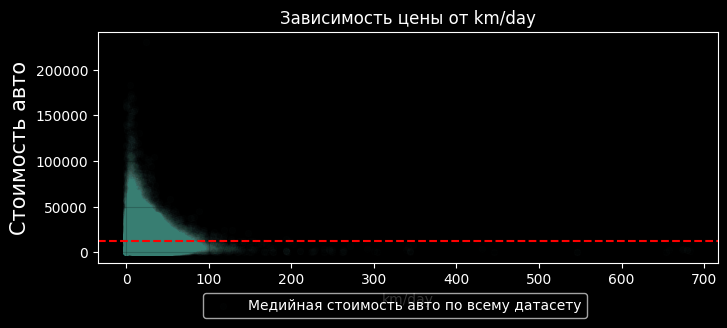

In [249]:
for column in num_cols:

    plot = df.plot(x=column,y=target,kind='scatter', 
                    cmap=plt.cm.summer, 
                    figsize=(8,3), rot=0, 
                    grid=True, legend=False, 
                    alpha = 0.01)

    plt.title(f'Зависимость цены от {column}')

    plt.ylabel('Стоимость авто',size = 15) 
    plt.axhline(y=round(df[target].agg(agg),5),
                color='red', linestyle='--', 
                label='Медийная стоимость авто')

    plt
    plt.grid(color='black',alpha=0.2)
    plt.legend(['Медийная стоимость авто по всему датасету'],fontsize='medium',bbox_to_anchor=(0.8, -0.1))
    plt.show()

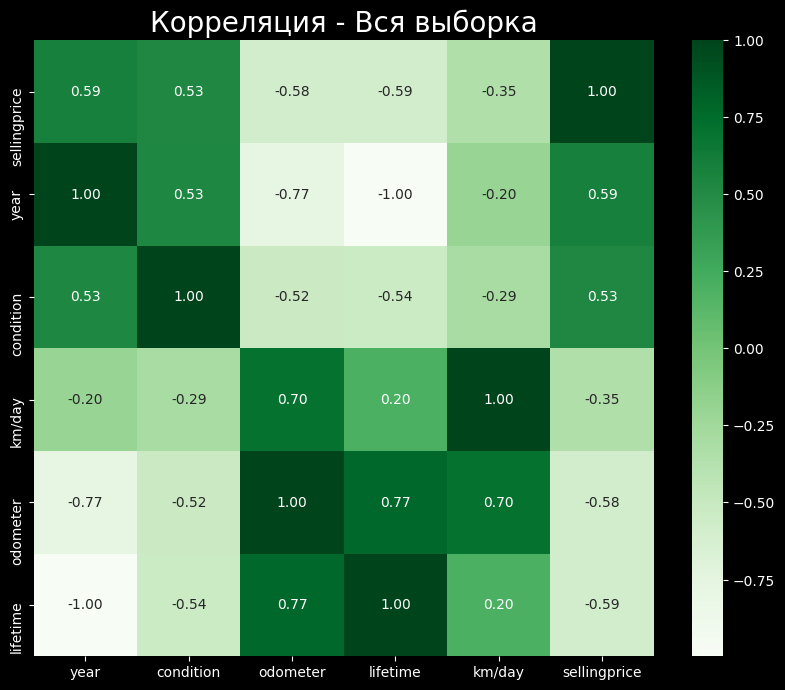

In [250]:
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols+[target]].corr().sort_values(by=target, ascending=False),
            annot=True, 
            cmap="Greens", 
            fmt='.2f')
plt.title('Корреляция - Вся выборка',size=20)
plt.show()

In [19]:
for i in train[cat_cols]:

    value_counts = train[i].value_counts()

    rare_values = value_counts[value_counts < 15].index.tolist()

    train[i] = train[i].apply(lambda x: 'rare' if x in rare_values else x)

for i in test[cat_cols]:

    value_counts = test[i].value_counts()

    rare_values = value_counts[value_counts < 6].index.tolist()

    test[i] = test[i].apply(lambda x: 'rare' if x in rare_values else x)

In [78]:
for i in train[cat_cols]: 
    display(train[i].value_counts().tail(2))

make
Geo           16
oldsmobile    15
Name: count, dtype: int64

model
mkt       15
Sephia    15
Name: count, dtype: int64

trim
ML350 BlueTEC 4MATIC    15
Track Edition           15
Name: count, dtype: int64

body
club cab         18
elantra coupe    18
Name: count, dtype: int64

transmission
unknown    51461
manual     13714
Name: count, dtype: int64

state
ns    52
al    19
Name: count, dtype: int64

color
pink    32
rare    14
Name: count, dtype: int64

interior
orange    109
yellow     16
Name: count, dtype: int64

seller
c&a auto ny corp           15
premier remarketing llc    15
Name: count, dtype: int64

In [20]:
def to_float(df,_):
    '''Функция преобразует формат столбце в минимально подходящий формат float
    на вход подаётся название датафрейма и столбца.'''
    df[_] = pd.to_numeric(df[_], downcast='float',errors='coerce')
    
def to_uint(df,_):
    '''Функция преобразует формат столбце в минимально подходящий формат гште
    на вход подаётся название датафрейма и столбца.'''
    df[_] = pd.to_numeric(df[_], downcast='unsigned',errors='coerce')

def to_int(df,_):
    '''Функция преобразует формат столбце в минимально подходящий формат гште
    на вход подаётся название датафрейма и столбца.'''
    df[_] = pd.to_numeric(df[_], downcast='integer',errors='coerce')

In [21]:
train['year'] = train['year'].dt.year
test['year'] = test['year'].dt.year

In [22]:
to_uint(train,'sellingprice')
to_uint(train,'lifetime')
to_uint(train,'year')
to_float(train,'odometer')
to_float(train,'condition')
to_float(train,'km/day')

to_uint(test,'lifetime')
to_uint(test,'year')
to_float(test,'odometer')
to_float(test,'condition')
to_float(test,'km/day')

In [23]:
train[cat_cols] = train[cat_cols].apply(lambda x: x.str.lower())
test[cat_cols] = test[cat_cols].apply(lambda x: x.str.lower())

In [30]:
df = train.copy().drop(['vin'], axis=1)
features = cat_cols + num_cols

X = df.drop([target], axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = s)

print('Размер признаков в обучабщей выборке:',X_train.shape[0])
print('Размер признаков в тестовой выборке:',X_test.shape[0])
print('Размер таргета в обучабщей выборке:',y_train.shape[0])
print('Размер таргета в тестовой выборке:',y_test.shape[0])

Размер признаков в обучабщей выборке: 352188
Размер признаков в тестовой выборке: 88048
Размер таргета в обучабщей выборке: 352188
Размер таргета в тестовой выборке: 88048


In [25]:
metric = 'MAPE'

ohe = ColumnTransformer([('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                               ('scaler', MinMaxScaler(), num_cols)],
                                remainder='passthrough')

oe = ColumnTransformer([('encoder', OrdinalEncoder(handle_unknown='error'), cat_cols),
                              ('scaler', MinMaxScaler(), num_cols)],
                               remainder='passthrough')

pd.options.display.float_format = '{: .3f}'.format

results = pd.DataFrame(columns=[metric,'Время обучения','Время предсказания'])
results

,MAPE,Время обучения,Время предсказания


In [26]:
def metrics(df,model,score,fit,pred):
    f'''Функция берёт на вход датафрейм, название модели, показаетль {metric} (по CV),
    время обучения и время предсказания. Добавляет строку с показателями модели.'''
    
    df.loc[model,'Время обучения'] = fit
    df.loc[model,'Время предсказания'] = pred
    df.loc[model, metric] = score
    
    return df

In [27]:
def grid_fit(model,params, cv=4, X_train=X_train, y_train=y_train):
    f"""Фукция берет на вход модель, и гиперпараметры для GridSearchCV.
    Проводит обучение с выявлением лучших гиперпараметров по метрике {metric}.
    Возвращает обученную модель, лучший {metric}, время обучения и предсказания модели."""
    
    grid = GridSearchCV(model, 
                        param_grid=params, 
                        scoring='neg_mean_absolute_percentage_error',
                        cv = cv)
        
    grid.fit(X_train,y_train)
    
    i = (list(grid.cv_results_['rank_test_score'])).index(1)
    score = grid.cv_results_['mean_test_score'][i]*-1
    time_fit = grid.cv_results_['mean_fit_time'][i]
    time_pred = grid.cv_results_['mean_score_time'][i]
    
    print('Лучшие параметры модели:', grid.best_params_)
    print(metric, score)
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)
    
    return grid, score, time_fit, time_pred

def random_fit(model, params, cv=4, X_train=X_train, y_train=y_train):
    """Функция берет на вход модель и гиперпараметры для RandomizedSearchCV.
    Проводит обучение с выявлением лучших гиперпараметров по метрике {metric}.
    Возвращает обученную модель, лучший {metric}, время обучения и предсказания модели."""

    random_search = RandomizedSearchCV(model,
                                       param_distributions=params,
                                       scoring='neg_mean_absolute_percentage_error',
                                       cv=cv)

    random_search.fit(X_train, y_train)

    i = (list(random_search.cv_results_['rank_test_score'])).index(1)
    score = random_search.cv_results_['mean_test_score'][i] * -1
    time_fit = random_search.cv_results_['mean_fit_time'][i]
    time_pred = random_search.cv_results_['mean_score_time'][i]

    print('Лучшие параметры модели:', random_search.best_params_)
    print(metric, score)
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)

    return random_search, score, time_fit, time_pred

def optuna_fit(model, params, cv=4, X_train=X_train, y_train=y_train, n_trials=10):
    """Функция берет на вход модель и гиперпараметры для байесовской оптимизации.
    Проводит ... обучение с выявлением лучших гиперпараметров по метрике {metric}.
    Возвращает обученную модель, лучший {metric}, время обучения и предсказания модели."""

    def objective(trial):
        # Определение пространства гиперпараметров
        param_values = {}
        for param_name, param_range in params.items():
            if isinstance(param_range, list):
                param_values[param_name] = trial.suggest_categorical(param_name, param_range)
            elif isinstance(param_range, tuple):
                if param_range[2] == int:
                    param_values[param_name] = trial.suggest_int(param_name, param_range[0], param_range[1])
                elif param_range[2] == float:
                    param_values[param_name] = trial.suggest_float(param_name, param_range[0], param_range[1])
                else:
                    raise ValueError("Неподдерживаемый тип гиперпараметра")
            else:
                raise ValueError("Неподдерживаемый тип гиперпараметра")

        # Установка гиперпараметров модели
        model.set_params(**param_values)

        # Выполнение кросс-валидации
        scores = -1*cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_percentage_error')

        return scores.mean()

    study = optuna.create_study(direction='minimize', pruner='Hyperband')
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    best_score = study.best_value
    time_fit = study.best_trial.duration.total_seconds()/cv
    time_pred = None  # В оптимизации с помощью Optuna нет времени предсказания

    print('Лучшие параметры модели:', best_params)
    print(metric, best_score)
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)

    return study, best_score, time_fit, time_pred


In [28]:
def pred(model):
    f"""Функция берёт на вход модель, обучает её на обучающей выборке,
    делает предсказания и проверяет {metric} на тестовой выборке.
    На выход идёт MAPE, время обучения и предсказания."""
    
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    time_fit = end - start

    start = time.time()
    preds = model.predict(X_test)
    end = time.time()
    score = mean_absolute_percentage_error(y_test, preds)
    time_pred = end - start
    
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)
    print(f'{metric}', score)
    
    return model, preds, score, time_fit, time_pred

In [277]:
%%time

model = LinearRegression()

pipe = Pipeline([('ohe', ohe),
                 ('lr', model)])

params = {
        'lr__fit_intercept': [False],
        'lr__copy_X': [False]
          }

study, score, time_fit, time_pred = optuna_fit(pipe, params, cv=4, n_trials=1)

metrics(results, 'LinearRegression_optuna_ohe', score, time_fit, time_pred)

[I 2023-08-19 00:41:15,524] A new study created in memory with name: no-name-f6555101-cd2f-44ca-b72d-1d5a3cba2bbd
[I 2023-08-19 00:42:27,139] Trial 0 finished with value: 0.5351536685795029 and parameters: {'lr__fit_intercept': False, 'lr__copy_X': False}. Best is trial 0 with value: 0.5351536685795029.


Лучшие параметры модели: {'lr__fit_intercept': False, 'lr__copy_X': False}
MAPE 0.5351536685795029
Время обучения модели: 17.90337125
Время предсказания модели: None
CPU times: total: 1min 8s
Wall time: 1min 11s


,MAPE,Время обучения,Время предсказания
LinearRegression_optuna_ohe,0.535,17.903,None


In [234]:
%%time

model = RandomForestRegressor(random_state=s)

pipe = Pipeline([('oe', oe),
                 ('rf', model)])

params = {
        'rf__n_estimators': (180,200,int)
        # 'rf__max_depth': (5,10,int)
        #'rf__min_samples_split': (2,10,int)
          }

study, score, time_fit, time_pred = optuna_fit(pipe, params, cv=4, n_trials=1)

metrics(results, 'RandomForestRegressor_optuna_oe2', score, time_fit, time_pred)

[I 2023-08-18 19:27:17,124] A new study created in memory with name: no-name-f602f496-b293-41ee-9c63-00a8a1407947
[I 2023-08-18 20:47:28,652] Trial 0 finished with value: 0.24275146512871526 and parameters: {'rf__n_estimators': 187}. Best is trial 0 with value: 0.24275146512871526.


Лучшие параметры модели: {'rf__n_estimators': 187}
MAPE 0.24275146512871526
Время обучения модели: 1202.87879525
Время предсказания модели: None
CPU times: total: 1h 17min 20s
Wall time: 1h 20min 11s


,MAPE,Время обучения,Время предсказания
LinearRegression_optuna_ohe,0.521,16.650,None
RandomForestRegressor_optuna_oe,0.263,636.691,None
RandomForestRegressor_optuna_oe2,0.243,1202.879,None


In [278]:
model = CatBoostRegressor(loss_function='RMSE',
                          random_state=s,
                          early_stopping_rounds=100,
                          verbose=False,
                          )

pipe = Pipeline([('ohe', ohe),
                 ('cbr', model)])

# Определение пространства гиперпараметров
params = {'cbr__learning_rate': (0.7, 1, float),
          'cbr__depth': (9, 10, int)
          }

# Обучение модели с помощью оптимизации с помощью Optuna
study, score, time_fit, time_pred = optuna_fit(pipe, params, cv=4, n_trials=10)

metrics(results, 'CatBoostRegressor_optuna_ohe', score, time_fit, time_pred)

[I 2023-08-19 00:43:30,958] A new study created in memory with name: no-name-c22711f8-a6df-4d91-9e51-afba21166a8d
[I 2023-08-19 00:51:36,594] Trial 0 finished with value: 0.20175562804275649 and parameters: {'cbr__learning_rate': 0.7414449889213465, 'cbr__depth': 9}. Best is trial 0 with value: 0.20175562804275649.
[I 2023-08-19 01:07:13,102] Trial 1 finished with value: 0.20096791387025986 and parameters: {'cbr__learning_rate': 0.7154510786988851, 'cbr__depth': 10}. Best is trial 1 with value: 0.20096791387025986.
[I 2023-08-19 01:21:29,040] Trial 2 finished with value: 0.19639524174978013 and parameters: {'cbr__learning_rate': 0.8527990168943758, 'cbr__depth': 10}. Best is trial 2 with value: 0.19639524174978013.
[I 2023-08-19 01:28:42,970] Trial 3 finished with value: 0.19980120665840242 and parameters: {'cbr__learning_rate': 0.9981543008386623, 'cbr__depth': 9}. Best is trial 2 with value: 0.19639524174978013.
[I 2023-08-19 01:42:10,427] Trial 4 finished with value: 0.1965913080392

Лучшие параметры модели: {'cbr__learning_rate': 0.7664715102048498, 'cbr__depth': 10}
MAPE 0.18939697527697968
Время обучения модели: 184.0090365
Время предсказания модели: None


,MAPE,Время обучения,Время предсказания
LinearRegression_optuna_ohe,0.535,17.903,None
CatBoostRegressor_optuna_ohe,0.189,184.009,None


In [237]:
model = CatBoostRegressor(loss_function='RMSE',
                          random_state=s,
                          early_stopping_rounds=100,
                          verbose=False,
                          )

pipe = Pipeline([('ohe', ohe),
                 ('cbr', model)])

# Определение пространства гиперпараметров
params = {'cbr__learning_rate': (0.7, 1, float),
          'cbr__depth': (8, 11, int)
          }

# Обучение модели с помощью оптимизации с помощью Optuna
study, score, time_fit, time_pred = optuna_fit(pipe, params, cv=4, n_trials=12)

metrics(results, 'CatBoostRegressor_optuna_ohe2', score, time_fit, time_pred)

[I 2023-08-18 22:12:16,533] A new study created in memory with name: no-name-9760a291-981c-43d3-9d46-2352fd7c1e3f
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2023-08-18 22:19:40,615] Trial 0 finished with value: 0.18909844061809616 and parameters: {'cbr__learning_rate': 0.8044545814784423, 'cbr__depth': 9}. Best is trial 0 with value: 0.18909844061809616.
[I 2023-08-18 22:26:52,856] Trial 1 finished with value: 0.21136253798274313 and parameters: {'cbr__learning_rate': 0.7535959879302504, 'cbr__depth': 9}. Best is trial 0 with value: 0.18909844061809616.
[I 2023-08-18 22:31:25,505] Trial 2 finished with value: 0.1987301999444365 and parameters: {'cbr__learning_rate': 0.7638994912586634, 'cbr__depth': 8}. Best is trial 0 with value: 0.18909844061809616.
[I 2023-08-18 22:42:47,992] Trial 3 finished with value: 0.20048564356223997 and parameters: {'cbr__learning_rate': 0.9270692630439754, 'cbr__depth': 10}. Best is trial 0 with value

Лучшие параметры модели: {'cbr__learning_rate': 0.8044545814784423, 'cbr__depth': 9}
MAPE 0.18909844061809616
Время обучения модели: 111.01972675
Время предсказания модели: None


,MAPE,Время обучения,Время предсказания
LinearRegression_optuna_ohe,0.521,16.650,None
RandomForestRegressor_optuna_oe,0.263,636.691,None
RandomForestRegressor_optuna_oe2,0.243,1202.879,None
CatBoostRegressor_optuna_ohe,0.191,84.319,None
CatBoostRegressor_optuna_ohe2,0.189,111.020,None


In [279]:
model = CatBoostRegressor(loss_function='RMSE',
                          random_state=s,
                          early_stopping_rounds=100,
                          verbose=1000,
                          learning_rate=0.77,
                          depth=10)

pipe = Pipeline([('ohe', ohe),
                 ('cbr', model)])

# Обучение модели с помощью оптимизации с помощью Optuna
model, preds, score, time_fit, time_pred = pred(pipe)

final = pd.DataFrame(columns=['Время обучения','Время предсказания','MAPE'])
metrics(final, 'CatBoostRegressor_optuna_ohe', score, time_fit, time_pred)

0:	learn: 6342.0531854	total: 238ms	remaining: 3m 58s
999:	learn: 1266.6804621	total: 3m 25s	remaining: 0us
Время обучения модели: 210.21479892730713
Время предсказания модели: 2.292292356491089
MAPE 0.1582503622502235


,Время обучения,Время предсказания,MAPE
CatBoostRegressor_optuna_ohe,210.215,2.292,0.158


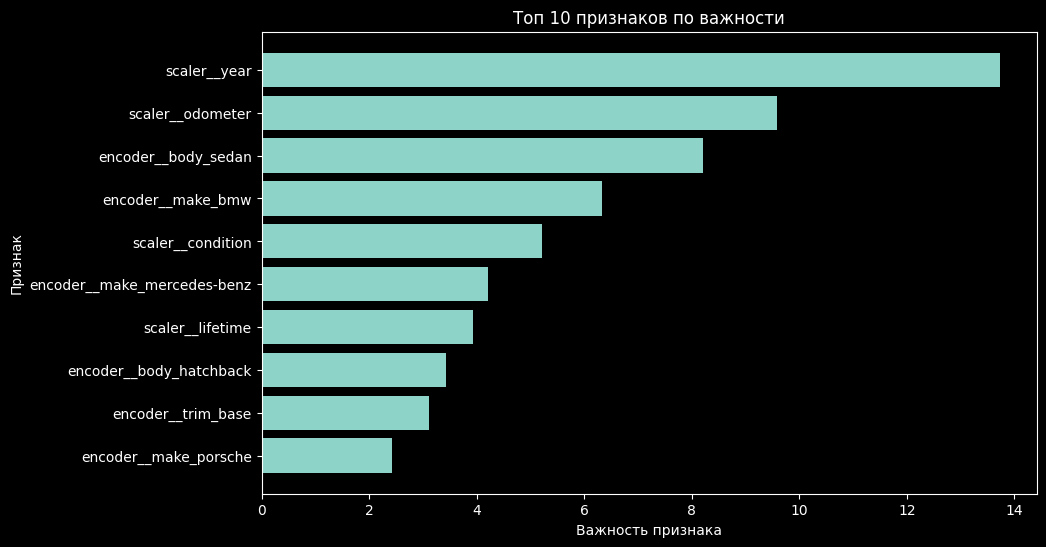

In [280]:

feature_importance = model.named_steps['cbr'].feature_importances_
feature_names = model.named_steps['ohe'].get_feature_names_out()
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Вывод важности признаков
top_n = 10  # Количество признаков для отображения
top_feature_names = sorted_feature_names[:top_n]
top_feature_importance = sorted_feature_importance[:top_n]
top_imp =pd.Series(top_feature_importance, index=top_feature_names).sort_values()

# Создание графика
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_imp, align='center')
plt.yticks(range(top_n), top_imp.index)
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Топ 10 признаков по важности')
plt.show()

In [244]:
pipe

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['make', 'model', 'trim',
                                                   'body', 'transmission',
                                                   'state', 'color', 'interior',
                                                   'seller']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['year', 'condition',
                                                   'odometer', 'lifetime',
                                                   'km/day'])])),
                ('cbr',
                 <catboost.core.CatBoostRegressor object at 0x00000136A5199E80>)])

In [31]:
model = CatBoostRegressor(loss_function='RMSE',
                          random_state=s,
                          early_stopping_rounds=100,
                          verbose=1000,
                          learning_rate=0.77,
                          depth=10)

pipe = Pipeline([('ohe', ohe),
                 ('cbr', model)])
                 
pipe.fit(train[features], train[target])
preds = pipe.predict(test[features])
predicted_data = pd.read_csv('sample_submission.csv')
predicted_data['sellingprice'] = preds
predicted_data

0:	learn: 6367.2043910	total: 399ms	remaining: 6m 38s
999:	learn: 1301.3524597	total: 4m 14s	remaining: 0us


,vin,sellingprice
0,1g6dp567450124779,4142.314
1,1gtw7fca7e1902207,21979.652
2,jn8az1mw6dw303497,19476.474
3,2g1wf5e34d1160703,8498.417
4,1n6aa0ec3dn301209,22588.902
...,...,...
110053,1j4aa2d17bl584330,16535.315
110054,jthbf1d23e5007526,28433.299
110055,1n4ba41e54c831950,4448.986
110056,jn1az4eh3dm382431,18025.267


In [ ]:
pipe.fit(train[features], train[target])
preds = pipe.predict(test[features])
predicted_data = pd.read_csv('sample_submission.csv')
predicted_data['sellingprice'] = preds
predicted_data

In [34]:
predicted_data.to_csv('predicted_data.csv',index=False)